## This Notebook can be executed. However, as the original data files were to big too include in the submission (~7.5 GB) we created mini-datasets. The code with which the original data was loaded is still provided in a Doc-String.

# Setup

Run the follwing cell to pip install the necerssary packages specified in the requirements.txt file.

In [1]:
#pip install -r requirements.txt

Importing the necessary packages

In [2]:
import os
import io
import tensorflow as tf
import numpy as np
from azure.storage.blob import BlobServiceClient, ContainerClient
from azure.core.exceptions import ResourceNotFoundError
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import time
from keras.models import load_model
import tempfile
import random

import pandas as pd
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Helper Functions 

- Training Accuracy and Loss Graphs:    plot_history(history)
- Predictions:                          print_predictions(inceptionv3_model, test_ds)
- True and Predicted Classes:           true_classes,predicted_classes = true_pred_classes(inceptionv3_model, test_ds)
- Accuracy:                             accuracy_score(true_classes,predicted_classes)
- F1 Score:                             f1_score(true_classes, predicted_classes, average='weighted')
- Recall:                               recall_score(true_classes, predicted_classes, average='weighted')
- Precision:                            precision_score(true_classes, predicted_classes, average='weighted')
- Confusion MAtrix (as Array):          conf_matrix = confusion_matrix(true_classes, predicted_classes)
- Plot Confusion Matrix:                print_conf_matrix(true_classes, predicted_classes,class_names)
- Upload a trained model to azure:      download_model_from_azure("model_name")
- Download a trained model from azure:  upload_model_to_azure(model, "model_name")

In [3]:
image_size=224
channels=3
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically


def plot_history(model):
    """Plots the accuracy and loss of the inputted model."""
    # summarize history for accuracy
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def plot_history_vgg(model):
    """Plots the accuracy and loss of the inputted model."""
    # summarize history for accuracy
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def create_labels (labels):
    y_labels = []
    for label in labels: 
        y_labels.append(label)
    y_labels = np.array(y_labels)
    return y_labels


def true_and_predicted_classes(predictions, labels):
    predicted_classes = []
    true_classes = []
    for prediction in predictions:  
        pred = np.argmax(prediction)
        predicted_classes.append(pred)
    for label in labels: 
        true = np.argmax(label)
        true_classes.append(true)
    return predicted_classes, true_classes


def print_predictions(labels, preds, predictions):
    """Predictions based on test dataset."""
    #predict
    for label,pred, prediction in zip(labels, preds, predictions):
        
            print("Prediction:", prediction,"Pred. Class: ",pred, "Actual Label:", label)# Print the first prediction
        

def evaluate_model(model, X_test, y_test):
    result = model.evaluate(X_test, y_test)
    # Assuming accuracy was the second metric (index 1), extract the accuracy.
    test_accuracy = result[1] * 100  # Convert to percentage
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


def print_conf_matrix(true_classes, predicted_classes):
    """
    Print confusion matrix.
    """
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    df_cm = pd.DataFrame(
        conf_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=(10,7))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')

    # Set aesthetics for better readability
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


def plot_image(index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Plot the image 
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Label: {class_names[y_true]}")
    plt.title("Image with Predicted and Actual Labels")
    plt.show()

def plot_image_pred(model, index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Predict the label using the model
    y_pred = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Image with Predicted and Actual Labels")
    plt.show()


def plot_wrong_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] != predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Wrong predicted image")
    plt.show()
    
def plot_correct_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] == predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}")
    plt.title("Correct predicted image")
    plt.show()


### Load Image Paths and Labels

In [4]:
######Following code was used for the inital process. But for submission mini datasets are provided to run the code.
"""
#read csv files to get filepaths and labels 
df_train= pd.read_csv("data/FINAL_METER_ML_train_2000.csv")
df_val = pd.read_csv("data/FINAL_METER_ML_val.csv")
df_test = pd.read_csv("data/FINAL_METER_ML_test.csv")

# convert each string in the DataFrame to a list
df_train['Label'] = df_train['Label'].apply(ast.literal_eval).apply(np.array)
df_val['Label'] = df_val['Label'].apply(ast.literal_eval).apply(np.array)
df_test['Label'] = df_test['Label'].apply(ast.literal_eval).apply(np.array)


#define class names for later use
class_names=["CAFOs","Landfills","Mines","Negative","ProcessingPlants","RefineriesAndTerminals","WWTreatment"]

#convert the label labels to arrays in a list
y_train = np.array(df_train['Label']).tolist()
y_val = np.array(df_val['Label']).tolist()
y_test = np.array(df_test['Label']).tolist()

#import images from previous created .npy files
X_val = np.load('data/x_val.npy')
X_test = np.load('data/x_test.npy')
X_train = np.load('data/x_train.npy')

#create labels
y_val = create_labels(y_val)
y_train = create_labels(y_train)
y_test = create_labels(y_test)
"""
class_names=["CAFOs","Landfills","Mines","Negative","ProcessingPlants","RefineriesAndTerminals","WWTreatment"]

### This is the code solely created for the mini datasets to make this notebook executeable 
#import images from previous created .npy files
X_val = np.load('data/x_val_mini.npy')
X_test = np.load('data/x_test_mini.npy')
X_train = np.load('data/x_train_mini.npy')

y_val = np.load('data/y_val_mini.npy')
y_test = np.load('data/y_test_mini.npy')
y_train = np.load('data/y_train_mini.npy')




# Models

## ResNet50: 
- https://datagen.tech/guides/computer-vision/resnet-50/
- https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
- https://medium.com/@ozgunhaznedar/image-classification-on-satellite-images-with-deep-learning-baa9813dde4e
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/The-Basics-of-ResNet50---Vmlldzo2NDkwNDE2#step-4:-building-resnet-50-model

### Transfer Learning

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.1400 - loss: 2.6888 - val_accuracy: 0.1000 - val_loss: 7.3485 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2800 - loss: 5.4913 - val_accuracy: 0.1000 - val_loss: 6.3326 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1600 - loss: 5.3002 - val_accuracy: 0.1000 - val_loss: 4.3030 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1200 - loss: 4.0487 - val_accuracy: 0.0200 - val_loss: 2.9689 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1200 - loss: 3.4302 - val_accuracy: 0.5600 - val_loss: 2.2410 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.1000 - loss: 3.1151 - val_accuracy: 0.1000 - val_loss: 2.4008 - learning_rate: 1.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3000 - loss: 2.7378 - val_acc

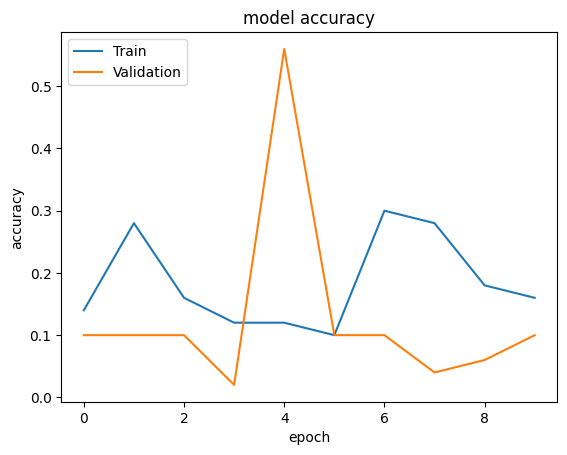

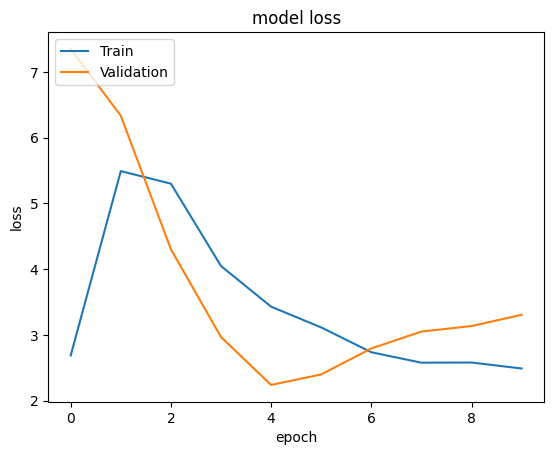

In [5]:
#set variables
train_epochs = 30
tune_epochs = 10
total_epochs = train_epochs + tune_epochs
batch_size = 128

# import resnet model for transfer learning
rn50_base = tf.keras.applications.ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape=(224,224,3)
    )

# Freeze layers pf basemodel, so the pre-trained weights are fixed
for each_layer in rn50_base.layers:
        each_layer.trainable=False

# create sequential model
resnet_model = Sequential()

# Add output layers for finetuning
resnet_model.add(rn50_base)
resnet_model.add(Flatten()) #use flatten instead of GlobalAveragePooling2D as it may yield better results when enough data
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))

# Compile model
resnet_model.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss= tf.keras.losses.CategoricalCrossentropy(), 
                    metrics = ['accuracy'])

#initializt time
t0 = time.time()

# Train model 
history = resnet_model.fit(X_train,
                        y_train,
                        validation_data = (X_val,y_val), 
                        epochs = train_epochs, 
                        batch_size=batch_size, 
                        callbacks = [ReduceLROnPlateau(patience=5), EarlyStopping(patience=5)])
t1 = time.time()

#print time in seconds
print("Training time in seconds:", t1-t0)
#save model
#resnet_model.save("resnet_model.keras")

# Plot model information
plot_history(history)


### Fine Tuning

In [6]:
#unfreeze last convolution layer for fine tuning
for each_layer in rn50_base.layers:
        each_layer.trainable=False
for layer in [l for l in rn50_base.layers if 'conv5' in l.name]:
   layer.trainable = True

#check if last concolution block has Trainable = True
for i, layer in enumerate(rn50_base.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_layer - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_con

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.2200 - loss: 2.2356 - val_accuracy: 0.1000 - val_loss: 3.3073 - learning_rate: 1.0000e-05
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6200 - loss: 1.6062 - val_accuracy: 0.1000 - val_loss: 3.3162 - learning_rate: 1.0000e-05
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6800 - loss: 1.1132 - val_accuracy: 0.1000 - val_loss: 3.3119 - learning_rate: 1.0000e-05
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9000 - loss: 0.5550 - val_accuracy: 0.1000 - val_loss: 3.2969 - learning_rate: 1.0000e-05
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9200 - loss: 0.4128 - val_accuracy: 0.1000 - val_loss: 3.2817 - learning_rate: 1.0000e-05
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9200 - loss: 0.3268 - val_accuracy: 0.1000 - val_loss: 3.2720 - learning_rate: 1.0000e-05
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9800 - loss: 0.1996 - val_acc

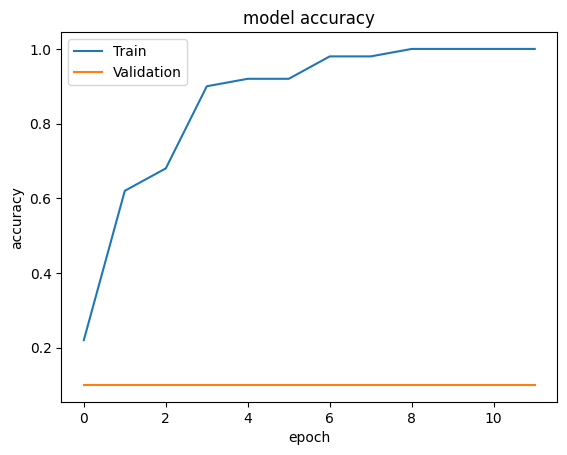

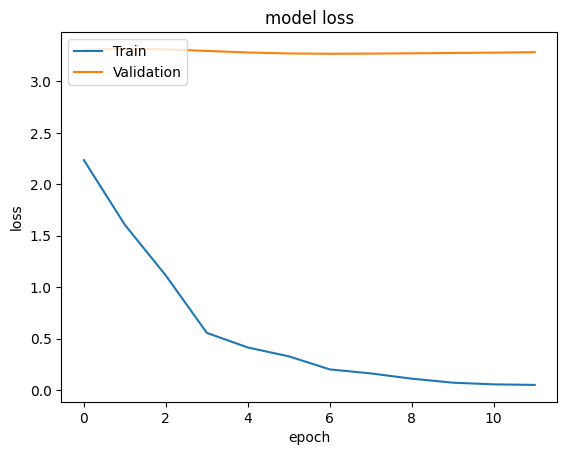

In [7]:
#compile the model with smaller learning rate
resnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                    loss = tf.keras.losses.CategoricalCrossentropy(), 
                    metrics=['accuracy'])

#initialize timing
t0 = time.time()

# Train model 
history = resnet_model.fit(X_train,
                        y_train,
                        validation_data = (X_val,y_val), 
                        epochs=total_epochs, 
                        batch_size=batch_size, 
                        callbacks = [ReduceLROnPlateau(patience=5), EarlyStopping(patience=5)])
t1 = time.time()
print("Training time in seconds:", t1-t0)

#save trained model
#resnet_model.save("resnet_model_tf.keras")

# Plot training plots
plot_history(history)


## Alexnet New

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1600 - loss: 1.9978 - val_accuracy: 0.0600 - val_loss: 2.0476 - learning_rate: 1.0000e-06
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1600 - loss: 1.9689 - val_accuracy: 0.0600 - val_loss: 2.0467 - learning_rate: 1.0000e-06
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1600 - loss: 1.9429 - val_accuracy: 0.0600 - val_loss: 2.0489 - learning_rate: 1.0000e-06
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1600 - loss: 1.9202 - val_accuracy: 0.0400 - val_loss: 2.0544 - learning_rate: 1.0000e-06
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2200 - loss: 1.9008 - val_accuracy: 0.0600 - val_loss: 2.0628 - learning_rate: 1.0000e-06
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2200 - loss: 1.8846 - val_accuracy: 0.1000 - val_loss: 2.0737 - learning_rate: 1.0000e-06
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2800 - loss: 1.8717 - val_accurac

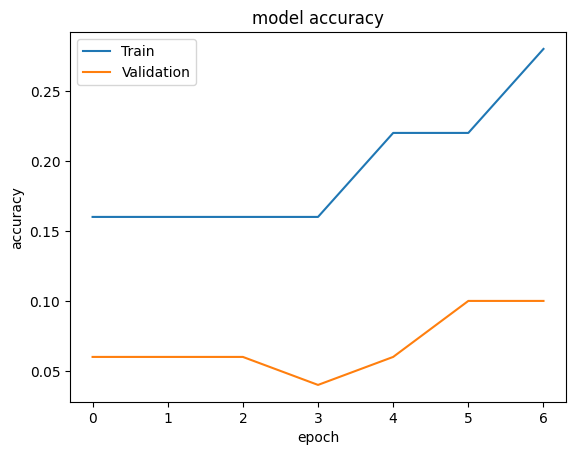

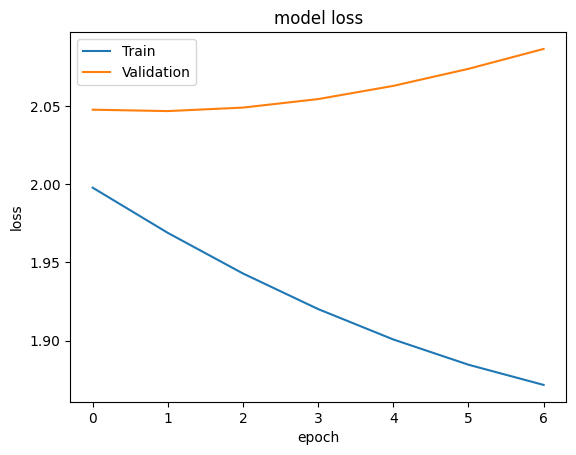

In [8]:
IMG_SIZE = 224
CHANNELS = 3

alexnet = Sequential()

alexnet.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= (224,224,3),
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

alexnet.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
                        
alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None))

alexnet.add(Flatten())
alexnet.add(Dense(4096, activation= 'relu'))
alexnet.add(Dense(4096, activation= 'relu'))

#Output layer with 7 classes insteas of 1000 as in model architecture:
alexnet.add(Dense(7, activation= 'softmax'))


# Compile the model with lower learning rate than Adam default:
alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#initialize timing
t0=time.time()

 #Fit model and save history for further analysis:
history = alexnet.fit(X_train,
                      y_train,
                      validation_data = (X_val, y_val), 
                      epochs=30,
                      batch_size=128,
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

print("Training time in seconds:", time.time()-t0)

#save model
#alexnet.save('alexnet.keras')

plot_history(history)

## VGG 16

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,289,223 (512.27 MB)

 Trainable params: 134,289,223 (512.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 0.1000 - loss: 1.9459 - val_accuracy: 0.1000 - val_loss: 1.9464 - learning_rate: 1.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - accuracy: 0.2800 - loss: 1.9452 - val_accuracy: 0.1000 - val_loss: 1.9469 - learning_rate: 1.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.2800 - loss: 1.9446 - val_accuracy: 0.1000 - val_loss: 1.9474 - learning_rate: 1.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.2800 - loss: 1.9438 - val_accuracy: 0.1000 - val_loss: 1.9480 - learning_rate: 1.0000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.2800 - loss: 1.9429 - val_accuracy: 0.1000 - val_loss: 1.9488 - learning_rate: 1.0000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.2800 - loss: 1.9418 - val_accuracy: 0.1000 - val_loss: 1.9498 - learning_rate: 1.0000e-05
Training time in seconds: 287.2166950702667


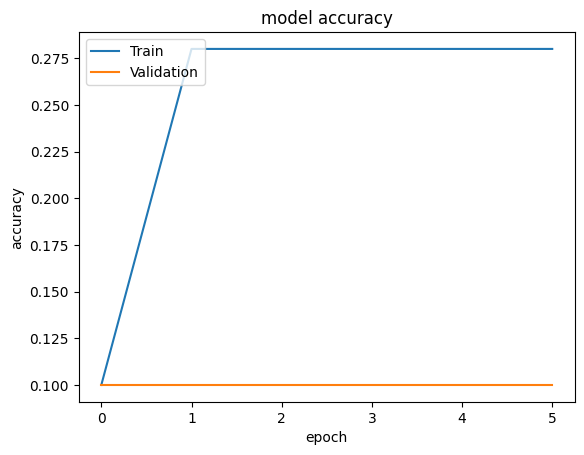

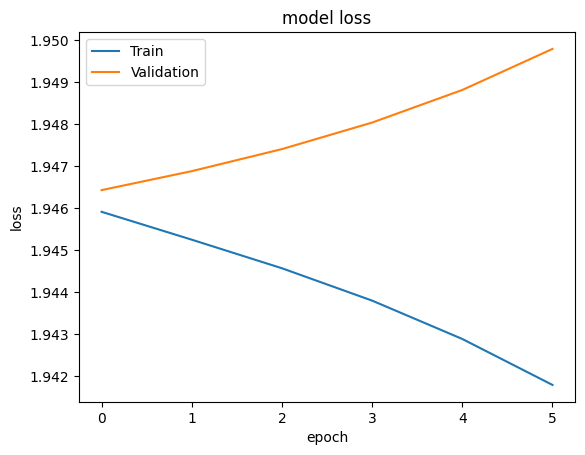

In [9]:
#Set Variables
epochs = 30
batch_size = 128

# Define Model
_input = Input((224,224,3)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(7, activation="softmax")(dense2) #adapted number of outputs and outputfunction

vgg16_model  = Model(inputs=_input, outputs=output)


#compile the model with lower learing rate than adama default:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

##provide a model summary
vgg16_model.summary()

#initialize timing
t0=time.time()

#fit the model
history = vgg16_model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [ReduceLROnPlateau(patience=5), EarlyStopping(patience=5)])

t1=time.time()
print("Training time in seconds:", t1-t0)

# save model:
#vgg16_model.save("vgg16_model.keras")

#Plot history
plot_history_vgg(vgg16_model)
